<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/sp500_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [ ]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sp500_price.csv to sp500_price.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sp500_price.csv'].decode('utf-8')))
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...,...
2510,2019-12-23,3226.050049,3227.780029,3222.300049,3224.010010,3224.010010,3060610000
2511,2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296540000
2512,2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2160680000
2513,2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2428670000


In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
df[['Volume']] = df[['Volume']].astype('float')

df_feature = df[['Close','Open','High','Low','Volume']]
df_feature.columns = [['close','open','high','low','volume']]
df_feature.head()

,close,open,high,low,volume
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09


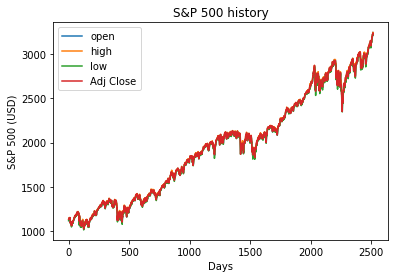

In [ ]:
### EDA
plt.figure()
plt.plot(df_feature[["open"]])
plt.plot(df_feature[["high"]])
plt.plot(df_feature[["low"]])
plt.plot(df[["Adj Close"]])
plt.title('S&P 500 history')
plt.ylabel('S&P 500 (USD)')
plt.xlabel('Days')
plt.legend(['open','high','low','Adj Close'], loc='upper left')
plt.show()


In [ ]:
data_train = df_feature.iloc[:2013, :]
data_test = df_feature.iloc[2013:, :]
print(data_train.shape, data_test.shape)

(2013, 5) (502, 5)


In [ ]:
# 一阶差分
scaler = MinMaxScaler(feature_range = (0,1))
train = scaler.fit_transform(data_train)
test = scaler.transform(data_test)

In [ ]:
y_train = np.array(df_feature.iloc[:2013, 0])
y_test = np.array(df_feature.iloc[2013:, 0])
print(y_train.shape, y_test.shape)

(2013,) (502,)


In [ ]:
past_steps = 15
next_steps = 1

In [ ]:
X_train = np.array([train[i : i + past_steps, :] for i in range(0, train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([test[i : i + past_steps, :] for i in range(0, test.shape[0] - (next_steps+ past_steps),1)])


In [ ]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])


In [ ]:
INPUT_DIM = data_train.shape[1]
output_dim = 1
batch_size = 8 #每轮训练模型时，样本的数量
epochs = 2000 #训练60轮次
hidden_size = 128
lstm_units = 64

In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression = LSTM_fun_keras_att(INPUT_DIM, X_train, y_train_regression, X_test, y_test_regression,seq_len=past_steps)


(None, 1, 32)
(None, 64)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 15, 32)       192         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 1, 32)        0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 1, 32)        0           max_pooling1d_4[0][0]            
______________________________________________________________

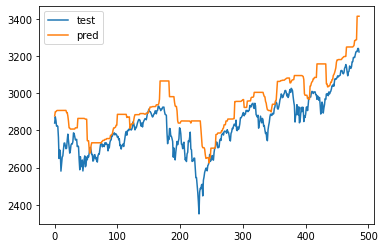

In [ ]:
# plot training history
plt.plot(y_test_regression, label='test')
plt.plot(y_pred_regression, label='pred')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

In [ ]:
print(MAPE(y_test_regression,y_pred_regression))

0.06816201860948744


In [ ]:
##### HS300

from google.colab import files
uploaded = files.upload()

Saving HS300.csv to HS300.csv


In [ ]:
import pandas as pd
import io

hs = pd.read_csv(io.StringIO(uploaded['HS300.csv'].decode('utf-8')))
hs

,date,p_close,open,high,low,close,volume
0,2010/1/4,3575.6840,3592.4680,3597.7480,3535.2290,3535.2290,6610108000
1,2010/1/5,3535.2290,3545.1860,3577.5260,3497.6610,3564.0380,8580964100
2,2010/1/6,3564.0380,3558.7000,3588.8320,3541.1730,3541.7270,7847312500
3,2010/1/7,3541.7270,3543.1600,3558.5560,3452.7690,3471.4560,8035003700
4,2010/1/8,3471.4560,3456.9080,3482.0830,3426.6980,3480.1300,6079025300
...,...,...,...,...,...,...,...
2426,2019/12/25,3992.9581,3988.6574,4000.5556,3976.3559,3990.8671,9493889000
2427,2019/12/26,3990.8671,3993.6686,4025.9879,3993.5413,4025.9879,10886064000
2428,2019/12/27,4025.9879,4029.2454,4066.7964,4019.7223,4022.0278,15092641100
2429,2019/12/30,4022.0278,4015.5195,4083.6901,4001.4951,4081.6334,15597148800


In [ ]:
hs.dtypes

date        object
p_close    float64
open       float64
high       float64
low        float64
close      float64
volume       int64
dtype: object

In [ ]:
hs[['volume']] = hs[['volume']].astype('float')
hs_feature = hs[['p_close','open','high','low','volume']]
hs_feature.columns = [['close','open','high','low','volume']]
hs_feature

,close,open,high,low,volume
0,3575.6840,3592.4680,3597.7480,3535.2290,6.610108e+09
1,3535.2290,3545.1860,3577.5260,3497.6610,8.580964e+09
2,3564.0380,3558.7000,3588.8320,3541.1730,7.847312e+09
3,3541.7270,3543.1600,3558.5560,3452.7690,8.035004e+09
4,3471.4560,3456.9080,3482.0830,3426.6980,6.079025e+09
...,...,...,...,...,...
2426,3992.9581,3988.6574,4000.5556,3976.3559,9.493889e+09
2427,3990.8671,3993.6686,4025.9879,3993.5413,1.088606e+10
2428,4025.9879,4029.2454,4066.7964,4019.7223,1.509264e+10
2429,4022.0278,4015.5195,4083.6901,4001.4951,1.559715e+10


In [ ]:
hs.iloc[:1944,:]

,date,p_close,open,high,low,close,volume
0,2010/1/4,3575.6840,3592.4680,3597.7480,3535.2290,3535.2290,6.610108e+09
1,2010/1/5,3535.2290,3545.1860,3577.5260,3497.6610,3564.0380,8.580964e+09
2,2010/1/6,3564.0380,3558.7000,3588.8320,3541.1730,3541.7270,7.847312e+09
3,2010/1/7,3541.7270,3543.1600,3558.5560,3452.7690,3471.4560,8.035004e+09
4,2010/1/8,3471.4560,3456.9080,3482.0830,3426.6980,3480.1300,6.079025e+09
...,...,...,...,...,...,...,...
1939,2017/12/25,4054.5984,4057.4173,4086.9342,4026.4496,4041.5401,9.192696e+09
1940,2017/12/26,4041.5401,4040.6173,4056.8554,4015.2996,4053.6224,9.111879e+09
1941,2017/12/27,4053.6224,4045.2793,4047.7366,3986.7385,3991.2075,1.051536e+10
1942,2017/12/28,3991.2075,3992.9970,4036.6975,3980.2358,4018.8974,1.185429e+10


In [ ]:
hs_train = hs_feature.iloc[:1944, :]
hs_test = hs_feature.iloc[1944:, :]
print(hs_train.shape, hs_test.shape)

(1944, 5) (487, 5)


In [ ]:
# 一阶差分
scaler = MinMaxScaler(feature_range = (0,1))
hs_train = scaler.fit_transform(hs_train)
hs_test = scaler.transform(hs_test)

In [ ]:
y_train_hs = np.array(hs_feature.iloc[:1944, 0])
y_test_hs = np.array(hs_feature.iloc[1944:, 0])
print(y_train_hs.shape, y_test_hs.shape)

(1944,) (487,)


In [ ]:
past_steps = 10
next_steps = 3

In [ ]:
X_train_hs = np.array([hs_train[i : i + past_steps, :] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
X_test_hs = np.array([hs_test[i : i + past_steps, :] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])


In [ ]:
y_train_regression_hs = np.array([y_train_hs[i + past_steps + next_steps] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression_hs = np.array([y_test_hs[i + past_steps + next_steps] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])


In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression_hs = LSTM_fun_keras_att(INPUT_DIM, X_train_hs, y_train_regression_hs, X_test_hs, y_test_regression_hs, seq_len=past_steps)


(None, 1, 32)
(None, 64)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 10, 32)       192         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 1, 32)        0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1, 32)        0           max_pooling1d_2[0][0]            
______________________________________________________________

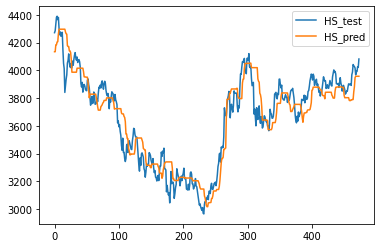

In [ ]:
# plot training history
plt.plot(y_test_regression_hs, label='HS_test')
plt.plot(y_pred_regression_hs, label='HS_pred')
plt.legend()
plt.show()

In [ ]:
print(MAPE(y_test_regression_hs,y_pred_regression_hs))

0.09969648393887008
